# XGBoost Regressor

1. The algorithm starts with a single decision tree as the base model. This decision tree makes predictions based on the input features.
2. The XGBoost Regressor then calculates the errors between the predicted and actual values for the training set.
3. It then creates a new decision tree that aims to reduce the errors made by the previous tree.
4. The algorithm combines the predictions from both decision trees to create a more accurate prediction.
5. The process of creating decision trees and combining their predictions continues iteratively until the model reaches a specified number of trees or the error rate no longer improves significantly.
6. XGBoost uses a gradient boosting technique to optimize the performance of the decision trees. Gradient boosting is a process of combining multiple weak models into a strong model. In each iteration, the algorithm identifies the weaknesses of the previous model and tries to improve them by creating a new model.
7. XGBoost also uses a regularization technique to prevent overfitting. It adds a penalty term to the loss function to discourage complex models that may fit the training data too closely.
8. Finally, XGBoost Regressor outputs the predictions based on the combined predictions of all the decision trees.

### Importing the libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("data/full.csv")
oil_df = pd.read_csv("data/oil.csv")
promo_elasticity_df = pd.read_csv("data/promotion_elasticity.csv")
oil_elasticity_df = pd.read_csv("data/oil_elasticity.csv")

In [3]:
df["date"] = pd.to_datetime(df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])

### Train / Test dataset

In [4]:
train_df = df.loc[df["date"] < "2017-04-16"]
test_df = df.loc[df["date"] > "2017-04-15"]

In [5]:
train_grocery = train_df[(train_df["family"] == "GROCERY I") & (train_df["store_nbr"] == 10)]
test_grocery = test_df[(test_df["family"] == "GROCERY I") & (test_df["store_nbr"] == 10)]

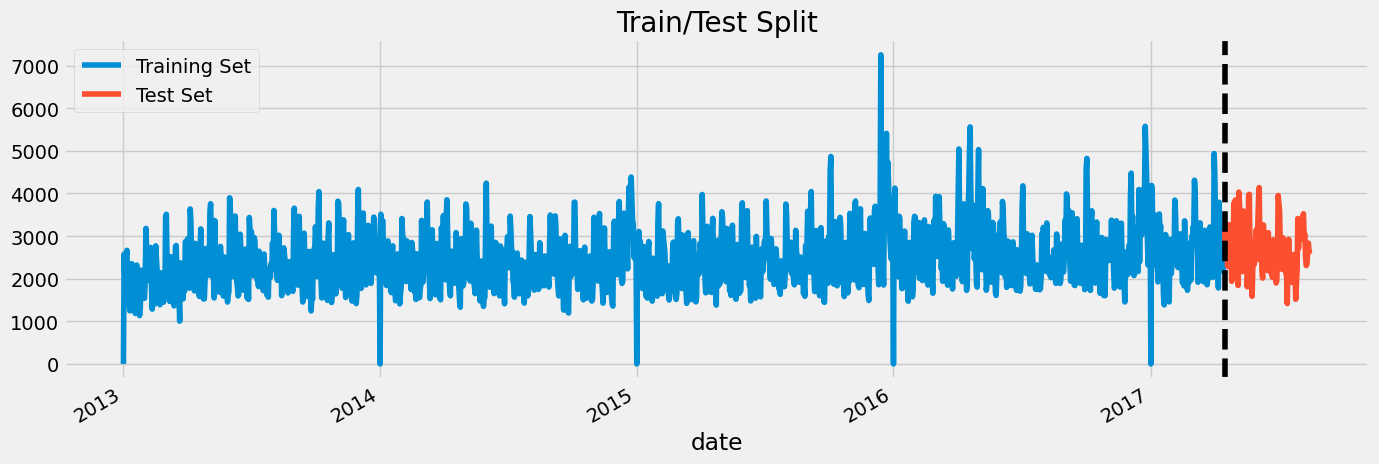

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train_grocery.plot(ax=ax, x="date", y="sales", label='Training Set', title='Train/Test Split')
test_grocery.plot(ax=ax, x="date", y="sales", label='Test Set')
ax.legend(['Training Set', 'Test Set'])
ax.axvline('2017-04-16', color='black', ls='--')
plt.show()

### Feature Creation

In [61]:
def create_time_features(df):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["week"] = df["date"].dt.isocalendar().week.astype("int32")
    df["day"] = df["date"].dt.day
    df['week_in_month'] = df['date'].apply(lambda x: (x.day-1)//7 + 1)
    df["day_of_week"] = df["date"].dt.dayofweek
    return df

def pattern_plot(pattern_df, period):
    pattern_period = pattern_df.groupby(["year", period])["sales"].sum().reset_index()
    sns.lineplot(pattern_period, x=period, y="sales", hue="year")

def merge_elasticity(df, promo, oil):
    df = df.copy()
    df = df.merge(promo, on="family")
    df = df.merge(oil, on="family")
    df = df.merge(oil_df, on="date", how="left")
    df = df.fillna(method="ffill")
    df = df.dropna()
    return df

def train_xgb(train, test, features, target, n_estimators, md, lr, early): 
    X_train = train[features]
    X_train = pd.get_dummies(X_train)
    y_train = train[target]

    X_test = test[features]
    X_test = pd.get_dummies(X_test)
    y_test = test[target]

    xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                    n_estimators=n_estimators,
                    early_stopping_rounds=early,
                    objective='reg:squarederror',
                    max_depth=md,
                    learning_rate=lr)
    xgb_model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    return xgb_model

def check_predictions(train, test, features, xgb_model):
    family_prediction = pd.DataFrame()
    test = test.copy()
    X_test = test[features]
    X_test = pd.get_dummies(X_test)
    average_sales = train.groupby("family")["sales"].mean()
    std_sales = train.groupby("family")["sales"].std()
    
    test["prediction"] = xgb_model.predict(X_test)
    test["mae"] = np.abs(test["sales"] - test["prediction"])
    
    family_prediction["avg_mae"] = test.groupby("family")["mae"].mean()
    family_prediction["pct_avg_sales"] = family_prediction["avg_mae"] / average_sales
    family_prediction["std_diff"] = family_prediction["avg_mae"] / std_sales
    family_prediction["worth_to_predict"] = family_prediction["std_diff"] < 1
    
    return (test, family_prediction)

def visualize_prediction(df, family, store_nbr):
    fig, ax = plt.subplots(figsize=(15, 5))
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="sales", label='Real value', title=f'{family}({store_nbr}): Real / Predicted value')
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="prediction", label='Predicted value')
    ax.legend(['Real value', 'Predicted value'])
    plt.show()
    df[df["family"]==family].plot.scatter(x="sales", y="prediction")

In [8]:
train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

In [17]:
base_features = ["store_nbr", "family", "onpromotion", "is_holiday", "type", "year", "month", "week", "day", "day_of_week"]
target = "sales"
xgb_base = train_xgb(train_df, test_df, base_features, target, 1000, 6, 0.03, 50)

[0]	validation_0-rmse:1109.32012	validation_1-rmse:1388.64582
[100]	validation_0-rmse:449.73322	validation_1-rmse:462.98895
[200]	validation_0-rmse:389.75492	validation_1-rmse:394.84516
[300]	validation_0-rmse:364.26179	validation_1-rmse:375.79269
[400]	validation_0-rmse:344.08176	validation_1-rmse:368.48905
[500]	validation_0-rmse:330.40283	validation_1-rmse:362.87022
[600]	validation_0-rmse:322.48723	validation_1-rmse:358.53526
[700]	validation_0-rmse:316.32716	validation_1-rmse:355.25582
[800]	validation_0-rmse:310.00553	validation_1-rmse:350.91049
[900]	validation_0-rmse:305.49971	validation_1-rmse:347.40991
[999]	validation_0-rmse:301.06926	validation_1-rmse:344.35071


In [18]:
base_mae, family_mae = check_predictions(train_df, test_df, base_features, xgb_base)

In [19]:
family_mae

,avg_mae,pct_avg_sales,std_diff,worth_to_predict
family,,,,
AUTOMOTIVE,57.205864,9.525765,9.204849,False
BABY CARE,48.248350,460.159635,70.721157,False
BEAUTY,55.303416,15.523236,11.959653,False
BEVERAGES,616.464927,0.268826,0.273310,True
BOOKS,48.151845,668.781793,85.465958,False
BREAD/BAKERY,117.203909,0.256914,0.320997,True
CELEBRATION,57.762281,7.250899,3.611062,False
CLEANING,302.164694,0.286408,0.417036,True
DAIRY,172.835242,0.249568,0.259085,True


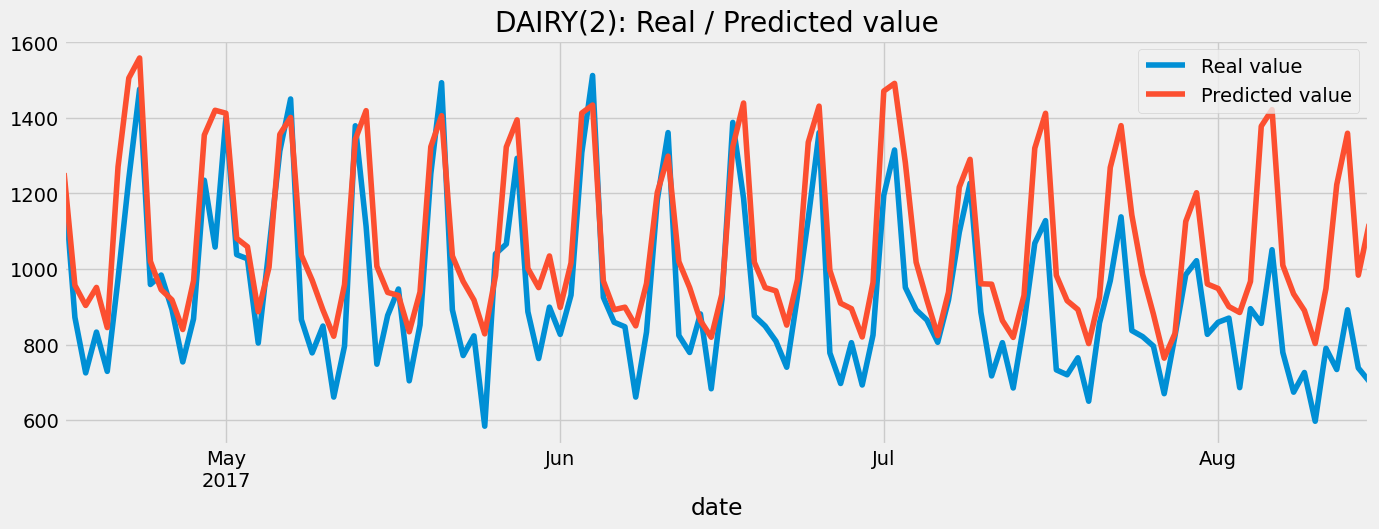

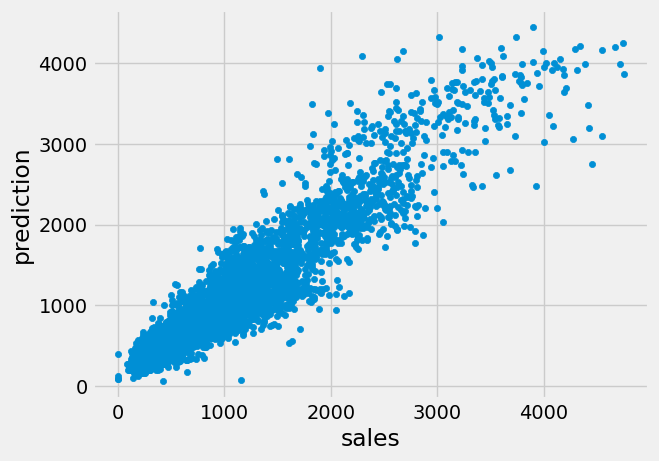

In [22]:
visualize_prediction(base_mae, "DAIRY", 2)

In [9]:
train_df = merge_elasticity(train_df, promo_elasticity_df, oil_elasticity_df)
test_df = merge_elasticity(test_df, promo_elasticity_df, oil_elasticity_df)

In [11]:
base_features = ["store_nbr", "family", "onpromotion", "is_holiday", "type", "year", "month", "week", "day", "day_of_week", "dcoilwtico"]
promo_features = ["mean_promo", "median_promo", "quantiles_promo"]
oil_features = ["mean_oil", "median_oil", "quantiles_oil"]

target = "sales"

In [23]:
models = {}
for promo in promo_features:
    for oil in oil_features:
        features = base_features + [promo] + [oil]
        model, used_variables = train_xgb(train, test, features, target, 1000, 6, 0.03, 50)
        models[promo+"_"+oil] = model  

[0]	validation_0-rmse:995.34945	validation_1-rmse:1241.48695
[500]	validation_0-rmse:320.71052	validation_1-rmse:322.39159
[850]	validation_0-rmse:294.51990	validation_1-rmse:308.58719
[0]	validation_0-rmse:995.34945	validation_1-rmse:1241.48695
[500]	validation_0-rmse:320.44061	validation_1-rmse:320.48286
[999]	validation_0-rmse:285.82951	validation_1-rmse:300.35635
[0]	validation_0-rmse:995.34945	validation_1-rmse:1241.48695
[500]	validation_0-rmse:322.20779	validation_1-rmse:320.89278
[822]	validation_0-rmse:294.92994	validation_1-rmse:306.33067
[0]	validation_0-rmse:995.34945	validation_1-rmse:1241.48695
[500]	validation_0-rmse:318.63944	validation_1-rmse:316.62661
[999]	validation_0-rmse:284.23402	validation_1-rmse:299.22860
[0]	validation_0-rmse:995.34945	validation_1-rmse:1241.48695
[500]	validation_0-rmse:318.71548	validation_1-rmse:317.94874
[999]	validation_0-rmse:284.45563	validation_1-rmse:298.96767
[0]	validation_0-rmse:995.34945	validation_1-rmse:1241.48695
[500]	validati

In [3]:
prediction_df = pd.read_csv("data/predictions/xgb_lr03_md6_base_oil_promo.csv")

In [4]:
prediction_df = prediction_df[["date", "store_nbr", "family", "sales", "prediction_mean_promo_mean_oil","prediction_mean_promo_median_oil","prediction_mean_promo_quantiles_oil","prediction_median_promo_mean_oil","prediction_median_promo_median_oil","prediction_median_promo_quantiles_oil","prediction_quantiles_promo_mean_oil","prediction_quantiles_promo_median_oil","prediction_quantiles_promo_quantiles_oil"]]

In [5]:
predicted_columns = ['prediction_mean_promo_mean_oil', 'prediction_mean_promo_median_oil',
       'prediction_mean_promo_quantiles_oil',
       'prediction_median_promo_mean_oil',
       'prediction_median_promo_median_oil',
       'prediction_median_promo_quantiles_oil',
       'prediction_quantiles_promo_mean_oil',
       'prediction_quantiles_promo_median_oil',
       'prediction_quantiles_promo_quantiles_oil']

In [81]:
def check_prediction_df(df, column):
    average_sales = df.groupby("family")["sales"].mean()
    std_sales = df.groupby("family")["sales"].std()
    family_prediction = pd.DataFrame()
    
    df = df[["date", "store_nbr", "family", "sales", column]]
    df = df.rename(columns={column: "prediction"})
    df["mae"] = np.abs(df["sales"] - df["prediction"])
    
    family_prediction["avg_mae"] = df.groupby("family")["mae"].mean()
    family_prediction["pct_avg_sales"] = family_prediction["avg_mae"] / average_sales
    family_prediction["std_diff"] = family_prediction["avg_mae"] / std_sales
    family_prediction["worth_to_predict"] = family_prediction["std_diff"] < 1
    
    return (df, family_prediction)

#### Check any family individual model results

In [82]:
quantiles_median_prediction, quantiles_median_family = check_prediction_df(prediction_df, 'prediction_quantiles_promo_median_oil')

In [83]:
models_predictions = {}
for column in predicted_columns:
    df_mae, family_stats = check_prediction_df(prediction_df, column)
    models_predictions[column] = {"predictions": df_mae, "stats":family_stats}

In [105]:
models_predictions["prediction_quantiles_promo_mean_oil"]["stats"]

,avg_mae,pct_avg_sales,std_diff,worth_to_predict
family,,,,
AUTOMOTIVE,22.033213,3.458586,4.589894,False
BABY CARE,25.621984,153.340233,39.807996,False
BEAUTY,30.831166,6.449300,6.476832,False
BEVERAGES,612.012474,0.195234,0.303194,True
BREAD/BAKERY,93.349532,0.184854,0.273126,True
CELEBRATION,27.211698,2.171131,1.944124,False
CLEANING,257.049430,0.217439,0.357136,True
DAIRY,146.249646,0.176906,0.251942,True
DELI,68.847332,0.238711,0.392664,True


In [57]:
stats_names = ['avg_mae', 'std_diff', 'pct_avg_sales']
agg_model_stats = pd.DataFrame()
for stat_name in stats_names:
    cols = pd.DataFrame([models_predictions[col]["stats"][stat_name] for col in predicted_columns])
    cols = cols.transpose()
    cols = cols.agg(["mean", "std"], axis=1)
    cols = cols.rename(columns={"mean": stat_name + "_mean", "std": stat_name + "_std"})
    agg_model_stats = pd.concat([agg_model_stats, cols], axis=1)

In [58]:
agg_model_stats

,avg_mae_mean,avg_mae_std,std_diff_mean,std_diff_std,pct_avg_sales_mean,pct_avg_sales_std
family,,,,,,
AUTOMOTIVE,22.005042,2.413717,4.584025,0.502818,3.454165,0.378885
BABY CARE,24.799353,1.130703,38.529902,1.756734,148.417021,6.766931
BEAUTY,32.912436,5.175586,6.914053,1.087257,6.884662,1.082635
BEVERAGES,613.905067,16.216470,0.304131,0.008034,0.195838,0.005173
BREAD/BAKERY,106.010096,8.957111,0.310169,0.026207,0.209925,0.017737
CELEBRATION,24.235041,3.619291,1.731459,0.258578,1.933634,0.288771
CLEANING,264.244745,4.893263,0.367133,0.006799,0.223525,0.004139
DAIRY,152.042986,5.128808,0.261922,0.008835,0.183913,0.006204
DELI,82.860723,11.655941,0.472588,0.066478,0.287299,0.040414


### Not worth prediction

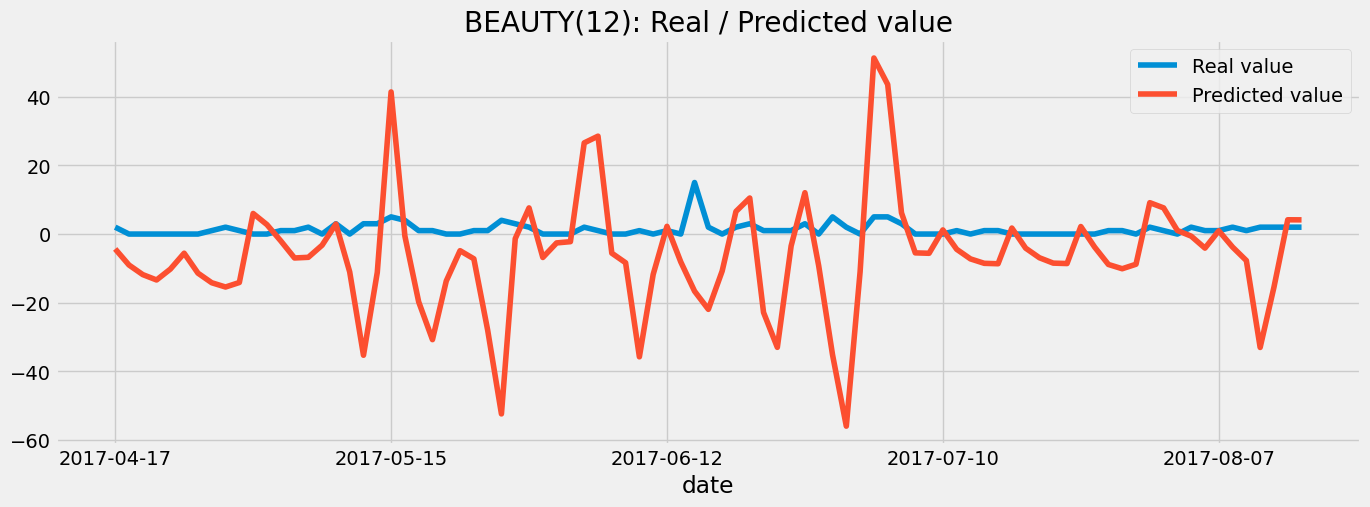

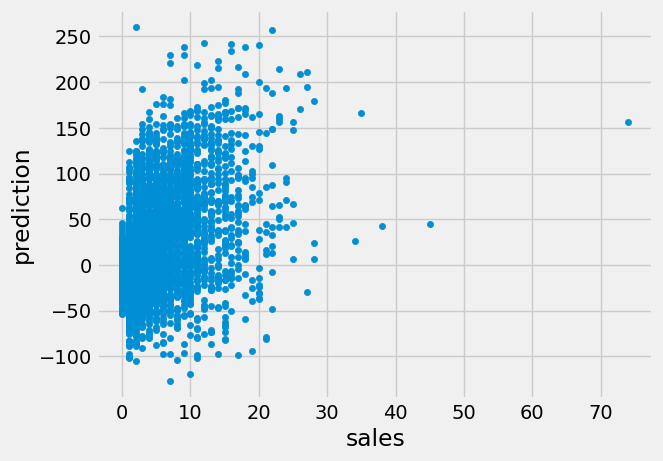

In [67]:
visualize_prediction(models_predictions["prediction_mean_promo_median_oil"]["predictions"], "BEAUTY", 12)

### Worth prediction

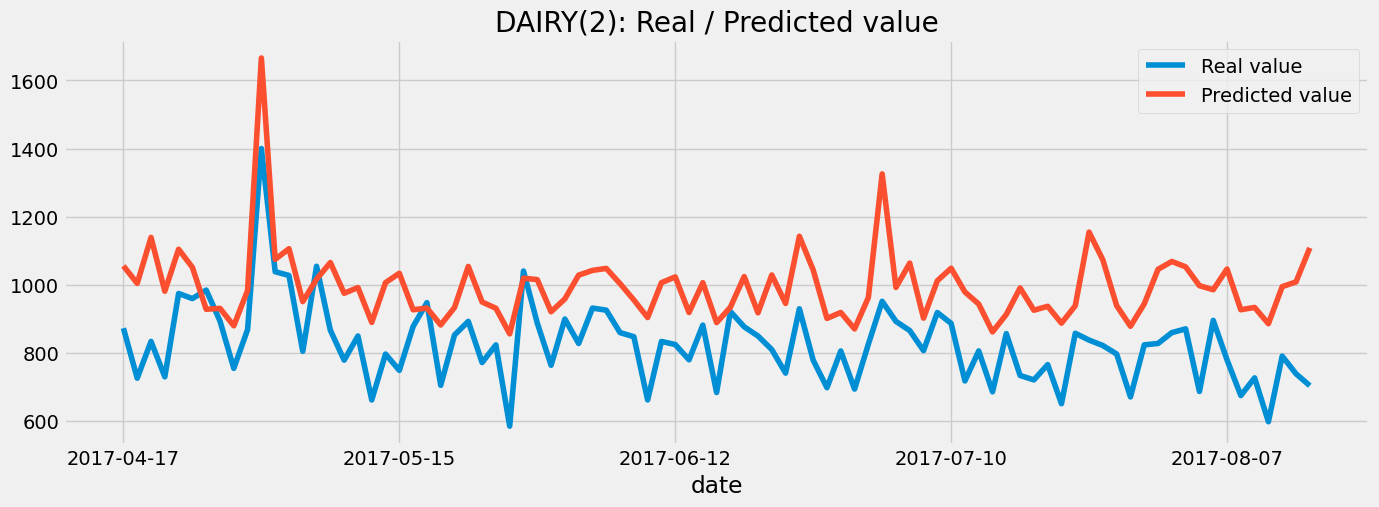

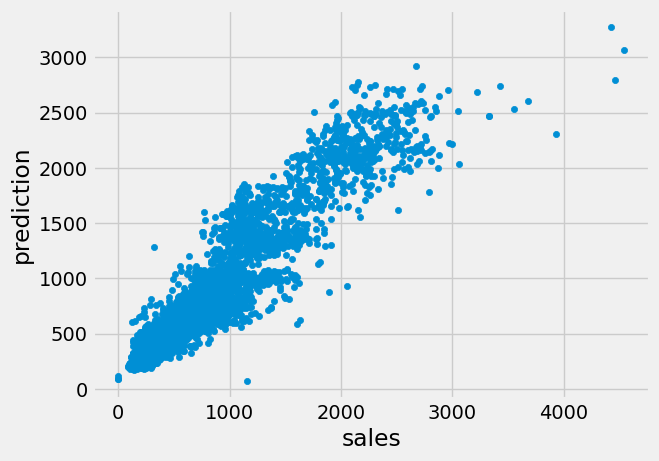

In [107]:
visualize_prediction(models_predictions["prediction_quantiles_promo_mean_oil"]["predictions"], "DAIRY", 2)